10. This question relates to the `College` data set.

In [9]:
library("ISLR2")
library("skimr")
library("ggplot2")
library("splines")
library("gam")
library("akima")
library("patchwork")
library("boot")
library("caret")
library("leaps")

In [3]:
head(College)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
Albertson College,Yes,587,479,158,38,62,678,41,13500,3335,500,675,67,73,9.4,11,9727,55


In [4]:
print(names(College))

 [1] "Private"     "Apps"        "Accept"      "Enroll"      "Top10perc"  
 [6] "Top25perc"   "F.Undergrad" "P.Undergrad" "Outstate"    "Room.Board" 
[11] "Books"       "Personal"    "PhD"         "Terminal"    "S.F.Ratio"  
[16] "perc.alumni" "Expend"      "Grad.Rate"  


In [5]:
skim(College)

── Data Summary ────────────────────────
                           Values 
Name                       College
Number of rows             777    
Number of columns          18     
_______________________           
Column type frequency:            
  factor                   1      
  numeric                  17     
________________________          
Group variables            None   

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts       
1 Private               0             1 FALSE          2 Yes: 565, No: 212

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable n_missing complete_rate    mean      sd     p0    p25    p50
 1 Apps                  0             1  3002.  3870.     81    776   1558  
 2 Accept                0             1  2019.  2451.     72    604   1110  
 3 Enroll                0             1   780.   929.     35

(a) Split the data into a training set and a test set.
Using out-of-state tuition as the response and the other variables as the predictors, perform forward stepwise selection on the training set in order to identify a satisfactory model that uses just a subset of the predictors.

In [10]:
train_rows <- createDataPartition(College$Outstate, p = 0.6, list = F)

X_train <- College[train_rows, ]
y_train <- College[train_rows, "Outstate"]
X_test <- College[-train_rows, ]
y_test <- College[-train_rows, "Outstate"]

dim(X_train)
dim(X_test)

[1] 468  18

[1] 309  18

In [11]:
print(names(X_train))

 [1] "Private"     "Apps"        "Accept"      "Enroll"      "Top10perc"  
 [6] "Top25perc"   "F.Undergrad" "P.Undergrad" "Outstate"    "Room.Board" 
[11] "Books"       "Personal"    "PhD"         "Terminal"    "S.F.Ratio"  
[16] "perc.alumni" "Expend"      "Grad.Rate"  


In [14]:
linreg_fit_fwd <- regsubsets(
    Outstate ~ .,
    data = X_train,
    nvmax = 17,
    method = "forward"
)
linreg_summary <- summary(linreg_fit_fwd)

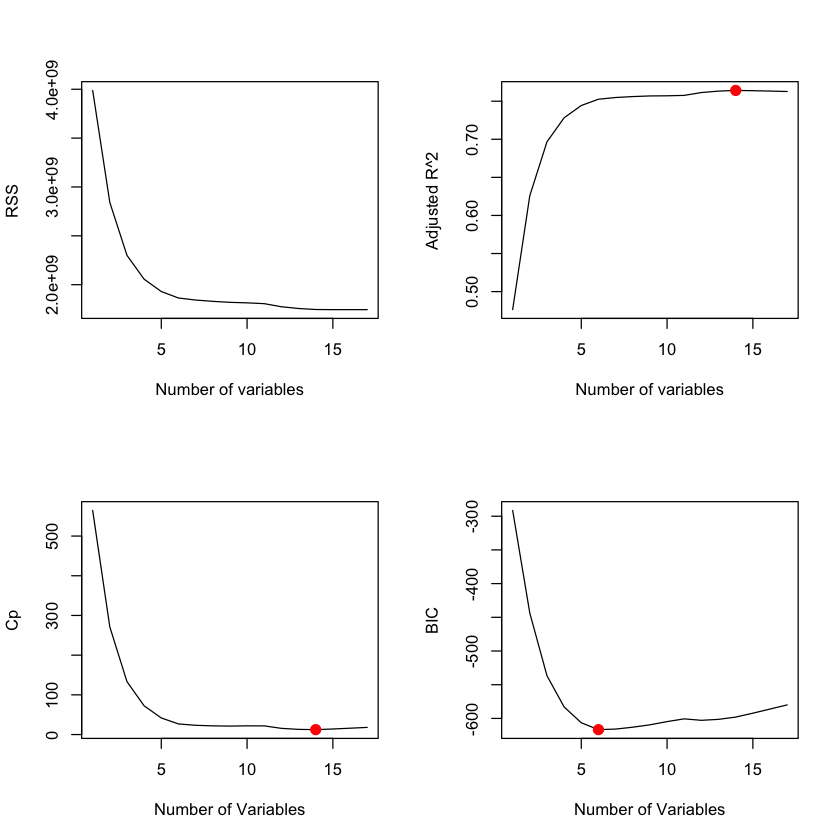

In [15]:
par(mfrow = c(2, 2))
plot(
    linreg_summary$rss,
    xlab = "Number of variables",
    ylab = "RSS",
    type = "l",
)
plot(
    linreg_summary$adjr2,
    xlab = "Number of variables",
    ylab = "Adjusted R^2",
    type = "l",
)

a <- which.max(linreg_summary$adjr2)

points(a, linreg_summary$adjr2[a],
    col = "red", cex = 2,
    pch = 20
)

plot(
    linreg_summary$cp,
    xlab = "Number of Variables",
    ylab = "Cp",
    type = "l"
)

b <- which.min(linreg_summary$cp)

points(b, linreg_summary$cp[b],
    col = "red", cex = 2, pch = 20
)

c <- which.min(linreg_summary$bic)

plot(
    linreg_summary$bic,
    xlab = "Number of Variables",
    ylab = "BIC", type = "l"
)

points(c, linreg_summary$bic[c],
    col = "red", cex = 2, pch = 20
)

We now try to choose among the models of different sizes using cross-validation. 
This approach is somewhat involved, as we must perform best subset selection within each of the $k$ training sets. Despite this, we see that with its clever subsetting syntax, `R` makes this job quite easy. 
First, we create a vector that allocates each observation to one of $k = 10$ folds, and we create a matrix in which we will store the results.

In [18]:
k <- 10
n <- nrow(X_train)
NUM_MODELS <- ncol(X_train) - 1
set.seed(1)
folds <- sample(rep(1:k, length = n))
cv_errors <- matrix(NA, k, NUM_MODELS, dimnames = list(NULL, paste(1:NUM_MODELS)))


Now we write a for loop that performs cross-validation. 
In the $j$-th fold, the elements of folds that equal $j$ are in the test set, and the remainder are in the training set. 
We make our predictions for each model size (using our new `predict_regsubsets()` method), compute the test errors on the appropriate subset, and store them in the appropriate slot in the matrix `cv.errors`. 

In [21]:
predict_regsubsets <- function(obj, newdata, id, ...) {
    form <- as.formula(obj$call[[2]])
    mat <- model.matrix(form, newdata)
    coefi <- coef(obj, id = id)
    xvars <- names(coefi)
    mat[, xvars] %*% coefi
}

for (j in seq(k)) {
    best_fit <- regsubsets(
        Outstate ~ .,
        data = X_train[folds != j, ],
        nvmax = NUM_MODELS
    )
    for (i in seq(NUM_MODELS)) {
        pred <- predict_regsubsets(best_fit, X_train[folds == j, ], id = i)
        cv_errors[j, i] <- mean((X_train$Outstate[folds == j] - pred)^2)
    }
}

This has given us a $10\times 17$ matrix, of which the $(j, i)$-th element corresponds to the test MSE for the $j$-th cross-validation fold for the best $i$-variable model. 
We use the `apply()` function to average over the columns of this matrix in order to obtain a vector for which the ith element is the cross-validation error for the $i$-variable model.

In [22]:
mean_cv_errors <- apply(cv_errors, 2, mean)
print(mean_cv_errors)

      1       2       3       4       5       6       7       8       9      10 
9604858 6733893 5153876 4850586 4628985 4298646 4490408 4576098 4297454 4338002 
     11      12      13      14      15      16      17 
4363260 4296686 4236562 4236480 4236091 4242354 4248187 


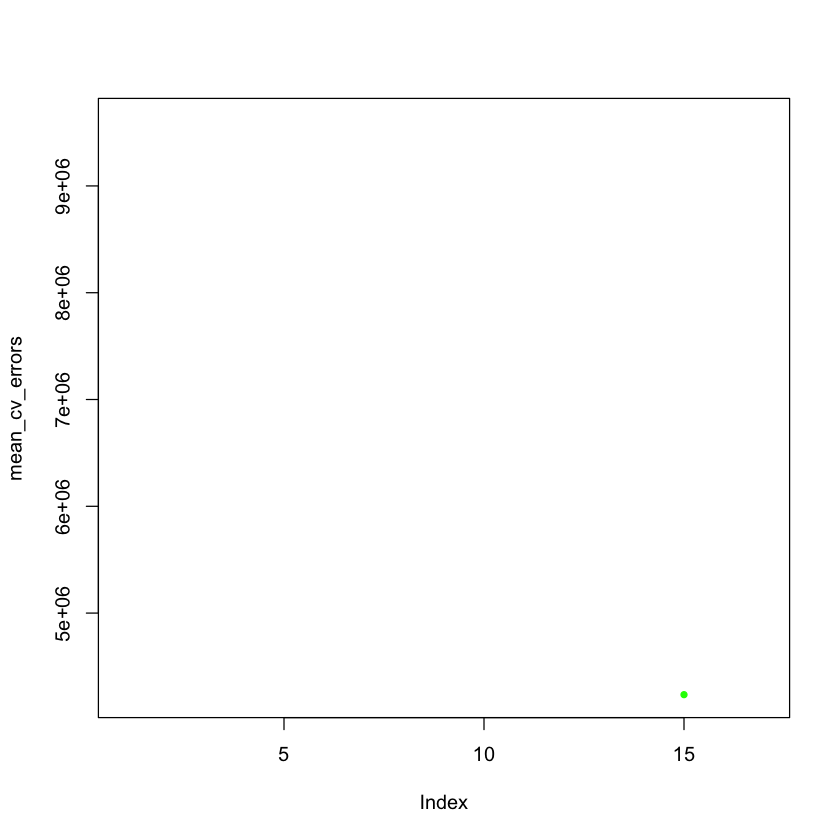

In [26]:
best_model <- which.min(mean_cv_errors)
plot(mean_cv_errors, type = "b", col = "white")
points(best_model, mean_cv_errors[best_model], col = "green", pch = 20)

We see that cross-validation selects a 15-variable model. 
We now perform best subset selection on the full data set in order to obtain the 15-variable model.
(This would be the `refit=true` option in the `sklearn` package)

In [28]:
linreg_best_cv <- regsubsets(Outstate ~ ., data = X_train, nvmax = NUM_MODELS)
print(coef(linreg_best_cv, 15))

  (Intercept)    PrivateYes          Apps        Accept        Enroll 
-1.793843e+03  2.219435e+03 -2.811492e-01  6.355690e-01 -2.724425e-01 
    Top10perc   F.Undergrad   P.Undergrad    Room.Board      Personal 
 1.428156e+01 -7.641604e-02 -3.214094e-02  9.666079e-01 -2.466962e-01 
          PhD      Terminal     S.F.Ratio   perc.alumni        Expend 
 1.896275e+01  1.719826e+01 -5.635836e+01  3.969929e+01  2.082775e-01 
    Grad.Rate 
 2.404530e+01 


In [38]:
linreg_pred <- predict_regsubsets(
    linreg_fit_fwd,
    newdata = X_test,
    id = 15)
mean((linreg_pred - y_test)^2)

[1] 3865951

In [39]:
linreg_pred_train <- predict_regsubsets(
    linreg_fit_fwd,
    newdata = X_train,
    id = 15
)
mean((linreg_pred_train - y_train)^2)

[1] 3728127